This notebook contains an implementation of the One Hundred Layers Tiramisu as described in Simon Jegou et al.'s paper [The One Hundred Layers Tiramisu: Fully Convolutional DenseNets for Semantic Segmentation](https://arxiv.org/abs/1611.09326). 

In [1]:
import tensorflow as tf
import keras
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, Cropping2D
from keras.regularizers import l2
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers import Conv2D, Conv2DTranspose, merge, concatenate, Lambda


Using TensorFlow backend.


In [2]:
%matplotlib inline
import importlib
# import utils2; importlib.reload(utils2)
# from utils2 import *

In [3]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore",category=DeprecationWarning)
import numpy as np
import keras.backend as K

In [10]:
r=np.random.rand(3,3)
print(r)
g = (r >= 0.5).astype(np.int32)


[[0.06599238 0.44086157 0.44425399]
 [0.16597055 0.43799355 0.66500001]
 [0.64311515 0.61364598 0.32943608]]


In [52]:
print(g)

[[1 0 0]
 [0 1 0]
 [1 1 1]]


In [3]:
limit_mem()

# Tiramisu / Camvid

Tiramisu is a fully-convolutional neural network based on DenseNet architecture. It was designed as a state-of-the-art approach to semantic image segmentation.

We're going to use the same dataset they did, CamVid.

CamVid is a dataset of images from a video. It has ~ 600 images, so it's quite small, and given that it is from a video the information content of the dataset is small. 

We're going to train this Tiramisu network from scratch to segment the CamVid dataset. This seems extremely ambitious!

## Setup

Modify the following to point to the appropriate paths on your machine

In [4]:
train_data = np.load('./data/train_data_anant.npy')
#train_data = train_data.reshape((367, 224, 224, 3))
#train_data = train_data.reshape((5, 224, 224, 3,2))
train_data_abnormal_labels = train_data.reshape((442, 224, 224, 3,2))
#train_label =  np.load('./data/train_label.npy')#[:,:,:-1]
train_label=  np.load('./data/train_label_anant.npy')#[:,:,:-1]
#train_label = train_label_abnormal[:,:,:,0]#[:,:,:-1]
train_data = train_data_abnormal_labels[:, :,:, :,0]
train_data = train_data.reshape((442, 224, 224, 3))
#print(train_data_disease.shape)
# test_data = np.load('./data/test_data.npy')
test_data=  np.load('./data/test_data_anant.npy')
# test_data = test_data.reshape((233, 224, 224, 3,2))
test_data_abnormal_labels = test_data.reshape((110, 224, 224, 3,2))
test_data = test_data_abnormal_labels[:, :,:, :,0]
test_data = test_data.reshape((110, 224, 224, 3))



# test_label = np.load('./data/test_label.npy')#[:,:,:-1]
#test_label = np.load('./data/test_label_sample.npy')#[:,:,:
test_label_abnormal = np.load('./data/test_label_anant.npy')#[:,:,:
test_label = test_label_abnormal

print(test_label.shape)
print(test_data.shape)
###

(110, 50176, 1, 2)
(110, 224, 224, 3)


In [28]:
test_label_temp = test_label[ :,:, :,0]
train_label_temp = train_label[ :,:, :,0]#[:,:,:-1]

In [248]:
print(test_label.shape)
print(test_data.shape)
print(train_label.shape)
print(train_data.shape)

(5, 50176, 1)
(5, 224, 224, 3)
(5, 50176, 1)
(5, 224, 224, 3)


In [91]:
hash_table = dict()

In [251]:
for i in range(len(train_label)):
    key = train_label[i,:,:].sum()
    value = train_label_abnormal[i,0,0,1]
    print(value)


1
1
0
0
0


In [187]:
print(len(test_label))
for i in range(len(test_label)):
    #print (test_label[i,0,0,1])
    print(test_label [:,:,:,1])

5


IndexError: too many indices for array

In [5]:
train_label[0].flatten().shape

(50176,)

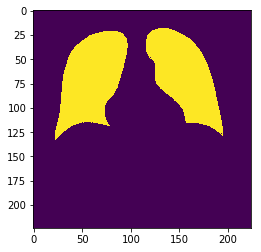

In [9]:
plt.imshow(test_label[0].flatten().reshape(224,224));

In [5]:
rnd_trn = len(train_label)
rnd_test = len(test_label)

## The Tiramisu

Now that we've prepared our data, we're ready to introduce the Tiramisu.

Conventional CNN's for image segmentation are very similar to the kind we looked at for style transfer. Recall that it involved convolutions with downsampling (stride 2, pooling) to increase the receptive field, followed by upsampling with deconvolutions until reaching the original side. 

Tiramisu uses a similar down / up architecture, but with some key caveats.

As opposed to normal convolutional layers, Tiramisu uses the DenseNet method of concatenating inputs to outputs. Tiramisu also uses *skip connections* from the downsampling branch to the upsampling branch.

Specifically, the *skip connection* functions by concatenating the output of a Dense block in the down-sampling branch **onto** the input of the corresponding Dense block in the upsampling branch. By "corresponding", we mean the down-sample/up-sample Dense blocks that are equidistant from the input / output respectively.

One way of interpreting this architecture is that by re-introducing earlier stages of the network to later stages, we're forcing the network to "remember" the finer details of the input image.

### The pieces

This should all be familiar.

In [6]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization(mode=0, axis=-1)(x)
def relu_bn(x): return relu(bn(x))
# def concat(xs): return merge(xs, mode='concat', concat_axis=-1)
def concat(xs): return concatenate(xs,axis=-1)

In [7]:
def conv(x, nf, sz, wd, p, stride=1): 
    x = Conv2D(nf, sz, sz, init='he_uniform', border_mode='same', 
                      subsample=(stride,stride), W_regularizer=l2(wd))(x)
    return dropout(x, p)

def conv_relu_bn(x, nf, sz=3, wd=0, p=0, stride=1): 
    return conv(relu_bn(x), nf, sz, wd=wd, p=p, stride=stride)

Recall the dense block from DenseNet.

In [8]:
def dense_block(n,x,growth_rate,p,wd):
    added = []
    for i in range(n):
        b = conv_relu_bn(x, growth_rate, p=p, wd=wd)
        c=Conv2D(x, kernel_size=(1, 1), padding='same',
                                  kernel_initializer="he_uniform")
        added.append(b)
    return x,added

This is the downsampling transition. 

In the original paper, downsampling consists of 1x1 convolution followed by max pooling. However we've found a stride 2 1x1 convolution to give better results.

In [9]:
def transition_dn(x, p, wd):
#     x = conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd)
#     return MaxPooling2D(strides=(2, 2))(x)
    return conv_relu_bn(x, x.get_shape().as_list()[-1], sz=1, p=p, wd=wd, stride=2)

Next we build the entire downward path, keeping track of Dense block outputs in a list called `skip`. 

In [10]:
def down_path(x, nb_layers, growth_rate, p, wd):
    skips = []
    for i,n in enumerate(nb_layers):
        x,added = dense_block(n,x,growth_rate,p,wd)
        skips.append(x)
        x = transition_dn(x, p=p, wd=wd)
    return skips, added

This is the upsampling transition. We use a deconvolution layer.

In [11]:
def transition_up(added, wd=0):
    x = concat(added)
    _,r,c,ch = x.get_shape().as_list()
    return Conv2DTranspose(ch, 3, 3, (None,r*2,c*2,ch), init='he_uniform', 
               border_mode='same', subsample=(2,2), W_regularizer=l2(wd))(x)
#     x = UpSampling2D()(x)
#     return conv(x, ch, 2, wd, 0)

This builds our upward path, concatenating the skip connections from `skip` to the Dense block inputs as mentioned.

In [12]:
def up_path(added, skips, nb_layers, growth_rate, p, wd):
    for i,n in enumerate(nb_layers):
        x = transition_up(added, wd)
        x = concat([x,skips[i]])
#         x = x+skips[i]
        x,added = dense_block(n,x,growth_rate,p,wd)
    return x

### Build the tiramisu model

- nb_classes: number of classes
- img_input: tuple of shape (channels, rows, columns) or (rows, columns, channels)
- depth: number or layers
- nb_dense_block: number of dense blocks to add to end (generally = 3)
- growth_rate: number of filters to add per dense block
- nb_filter:  initial number of filters
- nb_layers_per_block: number of layers in each dense block.
  - If positive integer, a set number of layers per dense block.
  - If list, nb_layer is used as provided
- p: dropout rate
- wd: weight decay

In [13]:
def reverse(a): return list(reversed(a))

Finally we put together the entire network.

In [17]:
# def create_tiramisu(nb_classes, img_input, nb_dense_block=6, 
#     growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):
    
#     if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
#         nb_layers = list(nb_layers_per_block)
#     else: nb_layers = [nb_layers_per_block] * nb_dense_block

#     x = conv(img_input, nb_filter, 3, wd, 0)
#     skips,added = down_path(x, nb_layers, growth_rate, p, wd)
#     x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
#     x = conv(x, nb_classes, 1, wd, 0)
#     _,r,c,f = x.get_shape().as_list()
#     x = Reshape((-1, nb_classes))(x)
#     return Activation('softmax')(x)

In [200]:

def create_tiramisu_reshape(nb_classes, img_input, nb_dense_block=6, 
    growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):
    newdim = tuple([x for x in img_input.get_shape().as_list() if x != 2 and x is not None])
    #newdim is now (15, 36). Reshape does not take batch size as an input dimension.
    img_input = Reshape(newdim) (img_input)
    print(img_input.get_shape().as_list())
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else: nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips,added = down_path(x, nb_layers, growth_rate, p, wd)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
    x = conv(x, nb_classes, 1, wd, 0)
    _,r,c,f = x.get_shape().as_list()
    x = Reshape((-1, nb_classes))(x)
    print(x.shape)
    print(x.get_shape().as_list())
    #return Activation('sigmoid')(x)
    x=Activation('sigmoid')(x)
    x=K.expand_dims(x, axis=3)
    
    print(x.get_shape().as_list())
    return x


In [14]:
##ADD THIS FOR CUSTOM LOSS
def add_dims(x):
    return K.expand_dims(x, axis=3)

In [15]:
##ADD THIS
def create_tiramisu(nb_classes, img_input, nb_dense_block=6, 
    growth_rate=16, nb_filter=48, nb_layers_per_block=5, p=None, wd=0):
    
    if type(nb_layers_per_block) is list or type(nb_layers_per_block) is tuple:
        nb_layers = list(nb_layers_per_block)
    else: nb_layers = [nb_layers_per_block] * nb_dense_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    skips,added = down_path(x, nb_layers, growth_rate, p, wd)
    x = up_path(added, reverse(skips[:-1]), reverse(nb_layers[:-1]), growth_rate, p, wd)
    
    x = conv(x, nb_classes, 1, wd, 0)
    _,r,c,f = x.get_shape().as_list()
    x = Reshape((-1, nb_classes))(x)
    print(x.shape)
    print(x.get_shape().as_list())
    x=Activation('sigmoid')(x)
    x=Lambda(add_dims)(x)
    
    print(x.get_shape().as_list())
    return x
    #return Activation('sigmoid')(x)

## Train

Now we can train. 

These architectures can take quite some time to train.

In [55]:
limit_mem()

In [16]:
input_shape = (224,224,3)
#input_shape = (224,224,3,2)

In [17]:
img_input = keras.Input(shape=input_shape)

In [18]:
x = create_tiramisu(1, img_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)

/home/leslie/mlmi/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), kernel_initializer="he_uniform", padding="same", strides=(1, 1), kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leslie/mlmi/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(axis=-1)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leslie/mlmi/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), kernel_initializer="he_uniform", padding="same", strides=(1, 1), kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/leslie/mlmi/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning

(?, ?, 1)
[None, None, 1]
[None, None, 1, 1]


/home/leslie/mlmi/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (1, 1), kernel_initializer="he_uniform", padding="same", strides=(1, 1), kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [93]:
#x = create_tiramisu(1, img_input, nb_layers_per_block=[4,5,7,10,12,15], p=0.2, wd=1e-4)

/Users/q453991/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), strides=(1, 1), padding="same", kernel_initializer="he_uniform", kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/q453991/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(axis=-1)`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/q453991/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), strides=(1, 1), padding="same", kernel_initializer="he_uniform", kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/q453991/anaconda3/lib/python3.6/site-packages/ipykerne

(?, ?, 1)
[None, None, 1]


/Users/q453991/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (1, 1), strides=(1, 1), padding="same", kernel_initializer="he_uniform", kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
##RESET
model = keras.Model(img_input, x)

In [20]:
#def loss_wrapper(hash_table):
def custom_acc(y_true, y_pred):
    return K.mean(y_pred)
# def custom_cross_entropy_1(y_true, y_pred):
#     #label=hash_table[K.sum(y_true)]
#     #print(label)
#     label=y_true[0,0,0,1]
#     label=.2
#     tf.Print("haha", y_true.get_shape().as_list())
#     y_true= y_true[:,:,:,0]
#     tf.Print( "haha",y_true.get_shape().as_list())
#     #print(label)
    
#     t_loss = K.max(y_pred,0) - y_pred*y_true + K.log(1+K.exp((-1)*K.abs(y_pred)))
#     t_loss =(1-0.2*label)*t_loss
#     return t_loss
#     #return custom_cross_entropy_1
##ANEES-EASY
def custom_cross_entropy_3(y_true, y_pred):
    #label=hash_table[K.sum(y_true)]
    #print(label)
    label=y_true[0,0,0,1]
    y_pred = y_pred[:,:,:,0]
    #label=.2
    #tf.Print("haha", y_true.get_shape().as_list())
    y_true = y_true[:,:,:,0]
    b_ce = K.binary_crossentropy(y_true, y_pred)
    #tf.Print( "haha",y_true.get_shape().as_list())
    #print(label)
    
    #t_loss = K.max(y_pred,0) - y_pred*y_true + K.log(1+K.exp((-1)*K.abs(y_pred)))
    t_loss =(1-0.2*label)*b_ce
    return K.mean(t_loss)
    #return t_loss
def custom_cross_entropy_2(y_true, y_pred):


    # Original binary crossentropy (see losses.py):
    # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)
    label=y_true[0,0,0,1]
    y_pred = y_pred[:,:,:,0]
    y_true = y_true[:,:,:,0]
    # Calculate the binary crossentropy
    b_ce = K.binary_crossentropy(y_true, y_pred)

    # Apply the weights
    weight_vector = y_true * 0.6+ (1. - y_true) * 0.4
    weighted_b_ce = weight_vector * b_ce
    final = (1-label)*b_ce + label*weighted_b_ce

    # Return the mean error
    return K.mean(final)
    #return final
   # return t_loss
    #return custom_cross_entropy_1

In [24]:
loss = custom_cross_entropy_2
model.compile(loss=loss, 
              optimizer=keras.optimizers.RMSprop(1e-3), metrics=[custom_acc])

In [376]:
# model.optimizer=keras.optimizers.Adam(lr=1e-3, decay=1-0.99995)

In [441]:
# model.optimizer=keras.optimizers.RMSprop(1e-3, decay=1-0.99995)

In [78]:
# model.optimizer=keras.optimizers.RMSprop(1e-3)

In [25]:
K.set_value(model.optimizer.lr, 1e-3)
batch_size = 5
nb_epoch=400

In [26]:
# model.fit_generator(gen, rnd_trn, 100, verbose=2, 
#                     validation_data=gen_test, nb_val_samples=rnd_test)
# model.fit_generator(train_data, rnd_trn, 100, verbose=2, 
#                     validation_data=gen_test, nb_val_samples=rnd_test)
history=model.fit(train_data, train_label, batch_size=batch_size, epochs=nb_epoch,verbose=2, validation_data=(test_data, test_label), shuffle=True)

Train on 442 samples, validate on 110 samples
Epoch 1/400
 - 23s - loss: 2.9327 - custom_acc: 0.1873 - val_loss: 2.8151 - val_custom_acc: 0.4154
Epoch 2/400
 - 17s - loss: 1.8814 - custom_acc: 0.2353 - val_loss: 2.0175 - val_custom_acc: 0.3279
Epoch 3/400
 - 17s - loss: 1.7376 - custom_acc: 0.2314 - val_loss: 2.3064 - val_custom_acc: 0.0689
Epoch 4/400
 - 17s - loss: 1.5234 - custom_acc: 0.2339 - val_loss: 1.7152 - val_custom_acc: 0.3458
Epoch 5/400
 - 17s - loss: 1.4063 - custom_acc: 0.2425 - val_loss: 1.7497 - val_custom_acc: 0.3637
Epoch 6/400
 - 17s - loss: 1.3891 - custom_acc: 0.2371 - val_loss: 1.7174 - val_custom_acc: 0.1293
Epoch 7/400
 - 17s - loss: 1.2907 - custom_acc: 0.2422 - val_loss: 1.3529 - val_custom_acc: 0.1882
Epoch 8/400
 - 17s - loss: 1.2386 - custom_acc: 0.2439 - val_loss: 1.1892 - val_custom_acc: 0.2601
Epoch 9/400
 - 17s - loss: 1.1468 - custom_acc: 0.2462 - val_loss: 1.1682 - val_custom_acc: 0.2253
Epoch 10/400
 - 17s - loss: 1.1393 - custom_acc: 0.2470 - val_l

Epoch 83/400
 - 18s - loss: 0.3751 - custom_acc: 0.2477 - val_loss: 0.3431 - val_custom_acc: 0.2504
Epoch 84/400
 - 18s - loss: 0.3810 - custom_acc: 0.2494 - val_loss: 0.3686 - val_custom_acc: 0.2616
Epoch 85/400
 - 18s - loss: 0.3735 - custom_acc: 0.2507 - val_loss: 0.5657 - val_custom_acc: 0.3255
Epoch 86/400
 - 18s - loss: 0.3721 - custom_acc: 0.2479 - val_loss: 0.4010 - val_custom_acc: 0.2418
Epoch 87/400
 - 18s - loss: 0.3626 - custom_acc: 0.2486 - val_loss: 0.6967 - val_custom_acc: 0.3413
Epoch 88/400
 - 18s - loss: 0.3544 - custom_acc: 0.2492 - val_loss: 0.3180 - val_custom_acc: 0.2985
Epoch 89/400
 - 18s - loss: 0.3525 - custom_acc: 0.2470 - val_loss: 0.3459 - val_custom_acc: 0.2804
Epoch 90/400
 - 18s - loss: 0.3579 - custom_acc: 0.2471 - val_loss: 0.3571 - val_custom_acc: 0.2276
Epoch 91/400
 - 18s - loss: 0.3535 - custom_acc: 0.2497 - val_loss: 0.4590 - val_custom_acc: 0.3007
Epoch 92/400
 - 18s - loss: 0.3265 - custom_acc: 0.2466 - val_loss: 0.3913 - val_custom_acc: 0.2221


Epoch 165/400
 - 18s - loss: 0.1626 - custom_acc: 0.2500 - val_loss: 0.2035 - val_custom_acc: 0.2969
Epoch 166/400
 - 18s - loss: 0.1537 - custom_acc: 0.2499 - val_loss: 0.1977 - val_custom_acc: 0.2911
Epoch 167/400
 - 18s - loss: 0.1573 - custom_acc: 0.2478 - val_loss: 0.1641 - val_custom_acc: 0.2579
Epoch 168/400
 - 18s - loss: 0.1587 - custom_acc: 0.2471 - val_loss: 0.1728 - val_custom_acc: 0.2634
Epoch 169/400
 - 18s - loss: 0.1566 - custom_acc: 0.2483 - val_loss: 0.1732 - val_custom_acc: 0.2416
Epoch 170/400
 - 18s - loss: 0.1500 - custom_acc: 0.2488 - val_loss: 0.1833 - val_custom_acc: 0.2357
Epoch 171/400
 - 18s - loss: 0.1487 - custom_acc: 0.2482 - val_loss: 0.2283 - val_custom_acc: 0.3049
Epoch 172/400
 - 18s - loss: 0.1524 - custom_acc: 0.2480 - val_loss: 0.1660 - val_custom_acc: 0.2667
Epoch 173/400
 - 18s - loss: 0.1488 - custom_acc: 0.2484 - val_loss: 0.1617 - val_custom_acc: 0.2370
Epoch 174/400
 - 18s - loss: 0.1557 - custom_acc: 0.2477 - val_loss: 0.1726 - val_custom_ac

 - 18s - loss: 0.1110 - custom_acc: 0.2474 - val_loss: 0.1370 - val_custom_acc: 0.2683
Epoch 247/400
 - 18s - loss: 0.1122 - custom_acc: 0.2467 - val_loss: 0.1285 - val_custom_acc: 0.2583
Epoch 248/400
 - 18s - loss: 0.1096 - custom_acc: 0.2477 - val_loss: 0.1446 - val_custom_acc: 0.2558
Epoch 249/400
 - 18s - loss: 0.1086 - custom_acc: 0.2476 - val_loss: 0.1403 - val_custom_acc: 0.2520
Epoch 250/400
 - 18s - loss: 0.1098 - custom_acc: 0.2474 - val_loss: 0.2006 - val_custom_acc: 0.2963
Epoch 251/400
 - 18s - loss: 0.1057 - custom_acc: 0.2475 - val_loss: 0.1358 - val_custom_acc: 0.2578
Epoch 252/400
 - 18s - loss: 0.1084 - custom_acc: 0.2483 - val_loss: 0.1721 - val_custom_acc: 0.2360
Epoch 253/400
 - 18s - loss: 0.1112 - custom_acc: 0.2468 - val_loss: 0.1283 - val_custom_acc: 0.2510
Epoch 254/400
 - 18s - loss: 0.1090 - custom_acc: 0.2472 - val_loss: 0.1336 - val_custom_acc: 0.2633
Epoch 255/400
 - 18s - loss: 0.1113 - custom_acc: 0.2474 - val_loss: 0.1345 - val_custom_acc: 0.2649
Epoc

Epoch 328/400
 - 18s - loss: 0.0975 - custom_acc: 0.2475 - val_loss: 0.1314 - val_custom_acc: 0.2668
Epoch 329/400
 - 18s - loss: 0.0955 - custom_acc: 0.2477 - val_loss: 0.1307 - val_custom_acc: 0.2755
Epoch 330/400
 - 18s - loss: 0.0971 - custom_acc: 0.2478 - val_loss: 0.1488 - val_custom_acc: 0.2679
Epoch 331/400
 - 18s - loss: 0.0959 - custom_acc: 0.2479 - val_loss: 0.1375 - val_custom_acc: 0.2432
Epoch 332/400
 - 18s - loss: 0.0971 - custom_acc: 0.2476 - val_loss: 0.1363 - val_custom_acc: 0.2423
Epoch 333/400
 - 18s - loss: 0.0965 - custom_acc: 0.2470 - val_loss: 0.1191 - val_custom_acc: 0.2640
Epoch 334/400
 - 18s - loss: 0.0961 - custom_acc: 0.2487 - val_loss: 0.1370 - val_custom_acc: 0.2524
Epoch 335/400
 - 18s - loss: 0.0952 - custom_acc: 0.2478 - val_loss: 0.1180 - val_custom_acc: 0.2530
Epoch 336/400
 - 18s - loss: 0.0953 - custom_acc: 0.2471 - val_loss: 0.1257 - val_custom_acc: 0.2487
Epoch 337/400
 - 18s - loss: 0.0949 - custom_acc: 0.2478 - val_loss: 0.1450 - val_custom_ac

## View results

Let's take a look at some of the results we achieved.

This is pretty good! We can see it is having some difficulty with the street between the light posts, but we would expect that a model that was pre-trained on a much larger dataset would perform better.

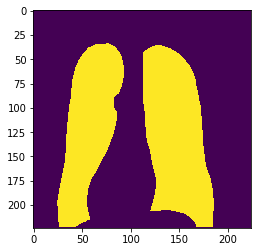

In [54]:
plt.imshow(np.resize(test_label_temp[33,:],(224,224)))

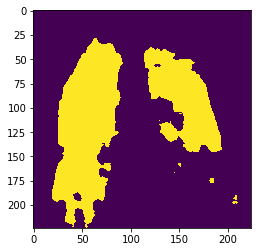

In [28]:
p = model.predict(np.expand_dims(test_data[33,:],0))
g = (p>=.5).astype(np.int32())
plt.imshow(np.resize(g,(224,224)))

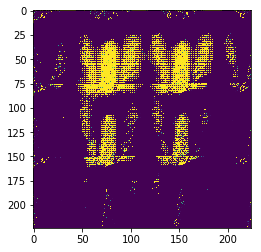

In [40]:
plt.imshow(np.resize(p,(224,224)))

## End

In [29]:
import os
path=os.getcwd()
if not os.path.exists(path+"/output_imgs_1_4_CustomLoss2/"):
        os.makedirs(path+"/output_imgs_1_4_CustomLoss2/")

In [30]:
# from scipy.misc import imsave
import matplotlib
for i in range(len(test_data)):
    p=model.predict(np.expand_dims(test_data[i,:],0))
    p=np.resize(p,(224,224))
#     if not os.path.exists(path+"/output_imgs/"):
#         os.makedirs(path+"/output_imgs/)
    g = (p>=0.5).astype(np.int32)
    matplotlib.image.imsave('output_imgs_1_4_CustomLoss2/outfile'+str(i)+'.png', g)
#     imsave('output_imgs/outfile'+i+'.jpg', p)

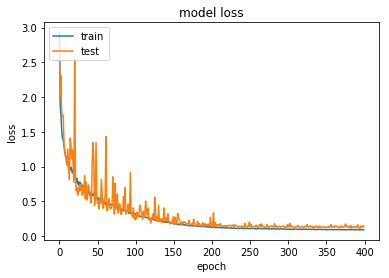

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()
plt.savefig('Loss Curve_1_4_CustomLoss2.png')

In [32]:
model.save_weights('weights/prop_tiramisu_1_4_CUSTOMLOSS2_weights_67_12_func_10-e7_decay{}.hdf5'.format(nb_epoch))

['val_custom_acc', 'loss', 'custom_acc', 'val_loss']


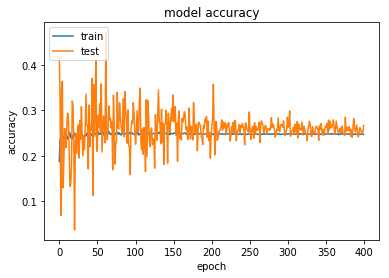

In [33]:
##save plots
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['custom_acc'])
plt.plot(history.history['val_custom_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.show()
plt.savefig('Model Accuracy Curve_1_4_CUSTOMLOSS2.png')
# summarize history for loss